In [1]:
import os
from imagegrains import grainsizing, plotting, segmentation_helper, data_loader, gsd_uncertainty
from cellpose import io
import pandas as pd
import matplotlib.pyplot as plt

## Complete ImageGrains analysis

### Segment image(s)

full_set_1 found...


F:/demo/K1/: 100%|██████████| 1/1 [00:36<00:00, 36.77s/image]


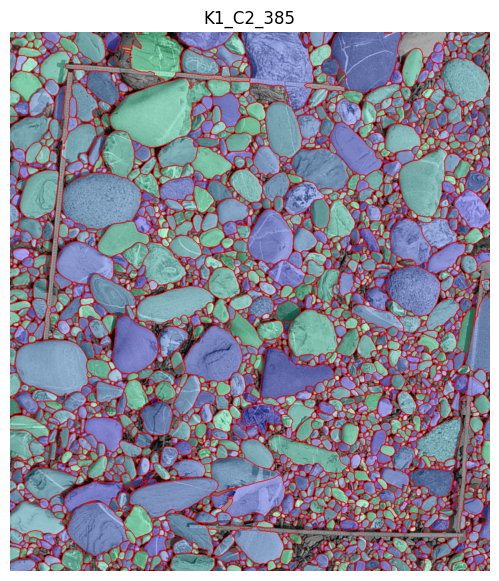

In [2]:
# Path to the images
IMAGE_PATH = 'F:/demo/K1/'
# Path to the segementation model
MODEL_PATH ='F:/git/grain_seg_ml/models/full_set_1.170223'
# Run segmentation
segmentation_helper.batch_predict(MODEL_PATH,IMAGE_PATH,mute=True,return_results=False,save_masks=True);
#get image and segmentation mask paths...
imgs,_,preds = data_loader.dataset_loader(IMAGE_PATH,pred_str='pred')
#... and plot them
plt.figure(figsize=(7,7))
plotting.plot_single_img_pred(imgs[0],preds[0])

### Optional filter and resample masks

image shape: 1200 x 1350
number of Wolman nodes: 51 x 58


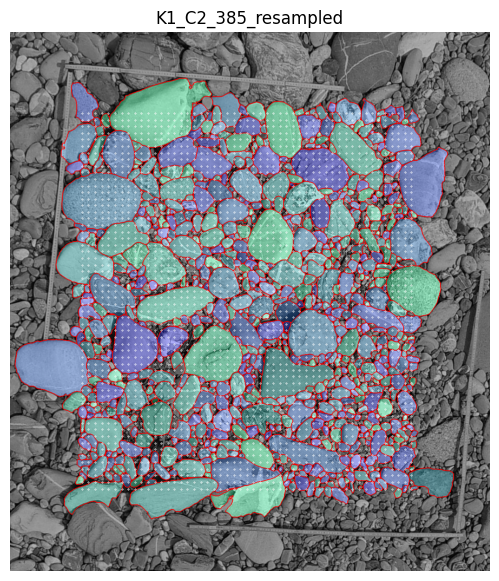

In [3]:
#load the segmentation masks from file
masks = io.imread(preds[0])
#define the filters to apply to the segmentation masks
filters= {'edge':[True,.15],'px_cutoff':[True,12]}
#resample masks and apply the filters
grid_resampled,xx,yy = grainsizing.resample_masks(masks,filters=filters,grid_size=16.5,mute=False)
#save resampled mask
io.imsave(IMAGE_PATH+'/K1_C2_385_resampled.tif',grid_resampled)
#plot resampled mask
plt.figure(figsize=(7,7))
plotting.plot_single_img_mask(io.imread(imgs[0]),grid_resampled,ID='K1_C2_385_resampled')
#plot grid
plt.scatter(yy,xx,marker='.',color='w',s=0.5);

### Calculate grain properties

F:/demo/K1//: 100%|██████████| 1/1 [00:01<00:00,  1.09s/file]


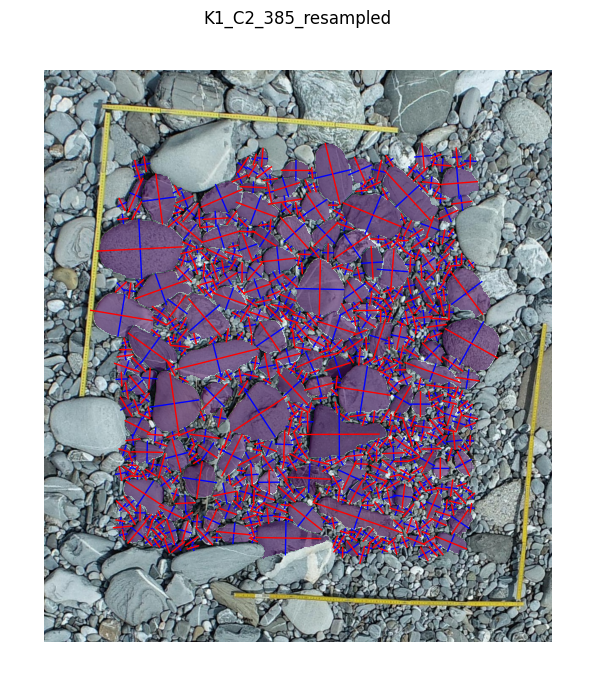

In [4]:
#measure the grains and save the results
grains,grains_props,grain_ID = grainsizing.batch_grainsize(IMAGE_PATH,filters=filters,mask_str='_resampled',mute=True,return_results=True)
#set the resolution in mm/px
resolution = 0.39
#scale with the image resolution
grainsizing.re_scale_dataset(IMAGE_PATH,resolution=resolution,gsd_str='_grains',save_gsds=True)

#define plot elements
elements= ['image','mask','ellipse_b','ellipse_a']
#plot
plt.figure(figsize=(7,7))
plotting.all_grains_plot(grid_resampled,props=grains_props[0],elements=elements,image=io.imread(imgs[0]),title=grain_ID[0])
plt.savefig(IMAGE_PATH+'/K1_C2_385_resampled_grains.png',dpi=300)

### Grain size distribution and uncertainty

In [5]:
#load the resampled grains
grains_scaled = data_loader.load_grain_set(IMAGE_PATH,gsd_str='resampled_grains_re_scaled')
#calculate the gsd for one column (e.g. b-axis with ellispe fit)
column_name = 'ell: b-axis (mm)'
#set uncertainty method
method = 'bootstrapping'
#calculate the gsd and uncertainty
res_dict_bs = gsd_uncertainty.dataset_uncertainty(gsds=grains_scaled,num_it=1000,method=method,mute=True,column_name=column_name,save_results=False,return_results=True,sep=',',gsd_id=grain_ID)

bootstrapping: 100%|██████████| 1/1 [00:00<00:00,  1.01gsd/s]


In [6]:
#compile full results into a dataframe and save it
full_gsd_results = pd.DataFrame({f'{column_name}_perc_lower_CI':res_dict_bs[grain_ID[0]][2],
                                f'{column_name}_perc_median':res_dict_bs[grain_ID[0]][0],
                                f'{column_name}_perc_upper_CI':res_dict_bs[grain_ID[0]][1],
                                f'{column_name}_perc_value':res_dict_bs[grain_ID[0]][3]})
#create output directory
out_dir = IMAGE_PATH + '/GSD_uncertainty/'
os.makedirs(out_dir,exist_ok=True)
#save the results
full_gsd_results.to_csv(f'{out_dir}/{grain_ID[0]}_{method}_full_uncertainty.csv')


In [7]:
# calculate and save key percentile summary
summary_df = grainsizing.summary_statistics(grains_scaled,grain_ID,res_dict=res_dict_bs,data_id=grain_ID[0],save_summary=True)
summary_df.head()

,Image/Masks,number of grains,D16,CI D16 (95%),D50,CI D50 (95%),D84,CI D84 (95%),D96,CI D96 (95%),unit,axis,method,grain approximation
0,K1_C2_385_resampled,597,5.4,[5.3 5.6],7.6,[7.3 8. ],13.6,[11.9 14.7],27.4,[22.6 30. ],mm,b-axis,bootstrapping,ellipse


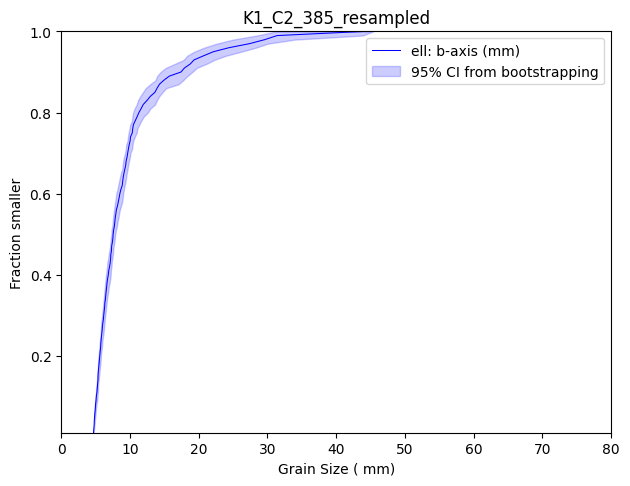

In [8]:
#plot gsd
plotting.plot_gsd(res_dict_bs[grain_ID[0]][3],color='b',length_max=80,orientation='vertical',label_axes=True,units= 'mm')
#plot uncertainty
plotting.plot_gsd_uncert(res_dict_bs[grain_ID[0]],color='b')
plt.legend([column_name,f'95% CI from {method}'])
plt.title(grain_ID[0]);